###**セル実行前にGPUをONにする**

##Google Driveにアクセスする

①google driveにlabelImageで出力したアノテーションフォルダ(アノテーション＋画像)をzip形式でアップロード

②google drive上でそのzipファイルの共有リンクをONにして、リンクを取得

③以下4セル目のid = 'xyz' にリンク(id以下)を格納

④zipファイルを解凍

⑤クラスファイル(labelImgで使用したクラス名を記述したテキストファイル)を別途アップロード

In [0]:
pip install -U -q PyDrive

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id = 'zipファイルの共有リンクid'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('hoge.zip')  # google driveにアップロードしたzipファイル

In [0]:
!unzip hoge.zip

Archive:  dog_cat2.zip
   creating: dog_cat2/
  inflating: dog_cat2/1905202.jpg    
  inflating: dog_cat2/1905202.xml    
  inflating: dog_cat2/33342_main1.jpg  
  inflating: dog_cat2/33342_main1.xml  
  inflating: dog_cat2/6239_ext_01_0.jpg  
  inflating: dog_cat2/6239_ext_01_0.xml  
  inflating: dog_cat2/catta.jpg      
  inflating: dog_cat2/catta.xml      
  inflating: dog_cat2/dog_img_long-chihuahua.jpg  
  inflating: dog_cat2/dog_img_long-chihuahua.xml  
  inflating: dog_cat2/dog_img_shiba.jpg  
  inflating: dog_cat2/dog_img_shiba.xml  
  inflating: dog_cat2/img_6b201e1a7a266ad253bf473f846d695e67132.jpg  
  inflating: dog_cat2/img_6b201e1a7a266ad253bf473f846d695e67132.xml  
  inflating: dog_cat2/img_71c53c1d81500a1cf73a4f543e72413f27838.jpg  
  inflating: dog_cat2/img_71c53c1d81500a1cf73a4f543e72413f27838.xml  
  inflating: dog_cat2/img_8db0612c13c0013326bfb1b66431df95645897.jpg  
  inflating: dog_cat2/img_8db0612c13c0013326bfb1b66431df95645897.xml  
  inflating: dog_cat2/large.jp

In [0]:
#クラスラベルが記述されたテキストファイルをアップロード
from google.colab import files
uploaded = files.upload()

Saving dog_cat.txt to dog_cat.txt


In [0]:
# 上記フォルダ、ファイルがアップロードされていることを確認
!ls

##データセット作成

In [0]:
!pip install xmltodict
#!pip install chainer
#!pip install chainercv

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import cv2
from PIL import Image
import xmltodict
from chainercv.chainer_experimental.datasets.sliceable import TupleDataset
from chainercv.visualizations import vis_bbox

In [0]:
!ls

adc.json  dog_cat2  dog_cat2.zip  dog_cat.txt  sample_data


In [0]:
#アップロードしたファイル名を格納
classes_file = 'クラスラベルファイル'
data_dir = 'zip解凍後のファイル'


In [0]:
classes = list()
with open(classes_file) as fd:
    for one_line in fd.readlines():
        cl = one_line.split('\n')[0]
        classes.append(cl)
print(classes)

['cat', 'dog']


In [0]:
def getBBoxData(anno_file, classes, data_dir):
    # xmlファイルのパース
    with open(anno_file, 'r', encoding = 'utf-8') as fd:
        pars = xmltodict.parse(fd.read())
    ann_data = pars['annotation']
    
    # 画像読み込み & サイズ変更
    img = Image.open(os.path.join(data_dir, ann_data['filename']))
    w, h = img.size
    img = img.resize((256,256))
    w_c, h_c = img.size
    w_rate, h_rate = w_c/w, h_c/h
    
    # Chainer入力用にarrayを変換 (W, H, C)→(C, H, W)
    img_arr = np.asarray(img).transpose(2,0,1).astype(np.float32)
    
    # bbox座標とクラスラベル読み込み
    bbox_list = list()
    obj_names = list()    
    obj = ann_data['object']
    bbox_list.append([obj['bndbox']['ymin'], obj['bndbox']['xmin'], obj['bndbox']['ymax'], obj['bndbox']['xmax']])
    bboxs = np.array(bbox_list, dtype=np.float32)
    # 画像サイズ変更したので、それに合わしてbboxの座標も変換する
    bboxs[0][0] = bboxs[0][0]*h_rate
    bboxs[0][1] = bboxs[0][1]*w_rate
    bboxs[0][2] = bboxs[0][2]*h_rate
    bboxs[0][3] = bboxs[0][3]*w_rate
    
    obj_names.append(obj['name'])
    obj_names = np.array(obj_names)
    
    obj_ids = np.array(list(map(lambda x:classes.index(x), obj_names)), dtype=np.int32)
    return {'img':img, 'img_arr':img_arr, 'bboxs':bboxs, 'obj_names':obj_names, 'obj_ids':obj_ids}

In [0]:
"""
# 画像データ、バウンディングボックス座標、クラス、クラスidが正確にダウンロードされているか確認したいときは
# コメントアウトを解除する
anno_files = glob.glob(os.path.join(data_dir, '*.xml'))
ret = getBBoxData(anno_file=anno_files[0], classes=classes, data_dir=data_dir)
print(ret)
"""

{'img': <PIL.Image.Image image mode=RGB size=256x256 at 0x7EFF253CCF60>, 'img_arr': array([[[250., 250., 250., ..., 225., 225., 226.],
        [250., 250., 250., ..., 224., 224., 226.],
        [250., 250., 250., ..., 225., 225., 226.],
        ...,
        [246., 246., 246., ..., 252., 252., 252.],
        [246., 246., 245., ..., 251., 252., 252.],
        [246., 246., 245., ..., 250., 251., 251.]],

       [[231., 231., 231., ..., 143., 143., 144.],
        [231., 231., 231., ..., 142., 142., 141.],
        [231., 231., 231., ..., 140., 140., 139.],
        ...,
        [227., 227., 227., ..., 230., 230., 231.],
        [227., 227., 226., ..., 229., 230., 231.],
        [227., 227., 226., ..., 230., 230., 230.]],

       [[216., 216., 216., ..., 121., 121., 122.],
        [214., 216., 216., ..., 120., 120., 120.],
        [214., 216., 216., ..., 119., 119., 119.],
        ...,
        [210., 210., 210., ..., 207., 207., 210.],
        [210., 210., 209., ..., 206., 207., 210.],
      

In [0]:
def getBBoxDataSet(data_dir, classes):
    anno_files = glob.glob(os.path.join(data_dir, '*.xml'))
     
    img_list = list()
    bboxs = list()
    obj_ids = list()
    
    for ann_file in anno_files:
        ret = getBBoxData(anno_file=ann_file, classes=classes, data_dir=data_dir)
        img_list.append(ret['img_arr'])
        bboxs.append(ret['bboxs'])
        obj_ids.append(ret['obj_ids'])
    imgs = np.array(img_list)
    return (imgs, bboxs, obj_ids)

In [0]:
imgs, bboxs, obj_ids = getBBoxDataSet(data_dir=data_dir, classes=classes)

In [0]:
## npy形式で保存
np.save(os.path.join(data_dir, 'images.npy'), imgs)
np.save(os.path.join(data_dir, 'bounding_box_data.npy'), bboxs)
np.save(os.path.join(data_dir, 'object_ids.npy'), obj_ids)

In [0]:
"""
# 確認用
print(imgs.shape)
print(len(bboxs))
print(len(obj_ids))
"""

'\n# 確認用\nprint(imgs.shape)\nprint(len(bboxs))\nprint(len(obj_ids))\n'

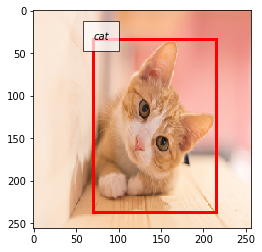

In [0]:
"""
# 確認用
dataset = TupleDataset(('img', imgs), ('bbox', bboxs), ('label', obj_ids))
tmp_img, tmp_bboxs, tmp_labels = dataset[0]
vis_bbox(tmp_img, tmp_bboxs, tmp_labels, label_names=classes)
plt.show()
"""

##学習

In [0]:
import matplotlib.pyplot as plt
import os
import numpy as np
import chainer
import random
#from chainercv import transforms
from chainercv.transforms import resize_bbox
from chainercv.transforms import random_flip
from chainercv.transforms import flip_bbox
from chainercv.chainer_experimental.datasets.sliceable import TupleDataset
from chainercv.links import FasterRCNNVGG16
from chainercv.links.model.faster_rcnn import FasterRCNNTrainChain
from chainer.datasets import TransformDataset
from chainer.datasets import split_dataset_random
from chainercv.visualizations import vis_bbox
from chainer import training
from chainer.training import extensions

In [0]:
classes_file = 'クラスラベルファイル'
data_dir = 'zip解凍後のファイル'
classes = list()
with open(classes_file) as fd:
    for one_line in fd.readlines():
        cl = one_line.split('\n')[0]
        classes.append(cl)

In [0]:
file_img_set = os.path.join(data_dir, 'images.npy')
file_bbox_set = os.path.join(data_dir, 'bounding_box_data.npy')
file_object_ids = os.path.join(data_dir, 'object_ids.npy')

In [0]:
imgs = np.load(file_img_set)
bboxs = np.load(file_bbox_set)
objectIDs = np.load(file_object_ids)
dataset = TupleDataset(('img', imgs), ('bbox', bboxs), ('label', objectIDs))

In [0]:
print(dataset)

以下セルを実行するとモデルがダウンロードされるので、1分30秒ほど待機する。

In [0]:
#Load model
faster_rcnn = FasterRCNNVGG16(n_fg_class=len(classes), pretrained_model='imagenet')
# プリセットされた閾値を使用する(Non Maximum Suppression)
faster_rcnn.use_preset('evaluate')

From: https://chainercv-models.preferred.jp/vgg16_imagenet_converted_2017_07_18.npz
To: /root/.chainer/dataset/_dl_cache/4f02fe8a8af16cdedf8200a6701dcb0a
  %   Total    Recv       Speed  Time left
100  490MiB  490MiB   7914KiB/s    0:00:00

In [0]:
# gpuを使わないときはgpu_id = -1にして4,5行目をコメントアウトする
gpu_id = 0
model = FasterRCNNTrainChain(faster_rcnn)
chainer.cuda.get_device_from_id(gpu_id).use()
model.to_gpu()

In [0]:
optimizer = chainer.optimizers.MomentumSGD(lr=0.001, momentum=0.9)
optimizer.setup(model)
# 重み減衰
optimizer.add_hook(chainer.optimizer_hooks.WeightDecay(rate=0.0005))

In [0]:
class Transform(object):

    def __init__(self, faster_rcnn):
        self.faster_rcnn = faster_rcnn

    def __call__(self, in_data):
        img, bbox, label = in_data
        _, H, W = img.shape
        img = self.faster_rcnn.prepare(img)
        _, o_H, o_W = img.shape
        scale = o_H / H
        bbox = resize_bbox(bbox, (H, W), (o_H, o_W))

        # horizontally flip
        img, params = random_flip(
            img, x_random=True, return_param=True)
        bbox = flip_bbox(
            bbox, (o_H, o_W), x_flip=params['x_flip'])

        return img, bbox, label, scale

In [0]:
# train:test = 0.8:0.2
N = len(dataset)
N_train = (int)(N*0.8)
N_test = N - N_train

In [0]:
# データの分割

idxs = list(np.arange(N))
random.shuffle(idxs)
train_idxs = idxs[:N_train]
test_idxs = idxs[N_train:]

train_data = TransformDataset(dataset[train_idxs], Transform(faster_rcnn))
train_iter = chainer.iterators.SerialIterator(train_data, batch_size=1)
test_iter = chainer.iterators.SerialIterator(dataset[test_idxs], batch_size=1, repeat=False, shuffle=False)

In [0]:
# 学習の設定
#updater = chainer.training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)
updater = chainer.training.StandardUpdater(train_iter, optimizer, device=gpu_id)
n_epoch = 20
out_dir = 'content'
trainer = training.Trainer(updater, (n_epoch, 'epoch'), out=out_dir)

In [0]:
step_size = 100 # 学習係数減少の間隔

trainer.extend(
    extensions.snapshot_object(model.faster_rcnn, 'snapshot_model.npz'),
    trigger=(n_epoch, 'epoch')) # モデルの出力. 出力タイミングは最後に指定(n_epoch毎に出力なので)
trainer.extend(extensions.ExponentialShift('lr', 0.1),
               trigger=(step_size, 'iteration')) # 学習係数”lr”を減少させる

log_interval = 1, 'epoch'
plot_interval = 1, 'epoch'
print_interval = 1, 'epoch'

trainer.extend(chainer.training.extensions.observe_lr(),
               trigger=log_interval) # LearningRateの記録

trainer.extend(extensions.LogReport(trigger=log_interval)) # trainerの経過状況をファイルに書き出す

trainer.extend(extensions.PrintReport(
    ['iteration', 'epoch', 'elapsed_time', 'lr',
     'main/loss',
     'main/roi_loc_loss',
     'main/roi_cls_loss',
     'main/rpn_loc_loss',
     'main/rpn_cls_loss',
     'validation/main/map',
    ]), trigger=print_interval)
# trainer.extend(extensions.ProgressBar(update_interval=10))

trainer.extend(
    extensions.PlotReport(
        ['main/loss'],
        file_name='loss.png', trigger=plot_interval
    ),
    trigger=plot_interval
) # ログの可視化

trainer.extend(extensions.dump_graph('main/loss'))

In [0]:
trainer.run()

iteration   epoch       elapsed_time  lr          main/loss   main/roi_loc_loss  main/roi_cls_loss  main/rpn_loc_loss  main/rpn_cls_loss  validation/main/map
8           1           3.27784       0.001       0.369579    0.276155           0.0787395          0.00954691         0.00513832                              
16          2           5.35604       0.001       0.3176      0.238302           0.062012           0.0136644          0.00362114                              
24          3           7.43789       0.001       0.352708    0.257614           0.0763464          0.0165058          0.00224231                              
32          4           9.50559       0.001       0.384152    0.274565           0.0749037          0.0326113          0.00207149                              
40          5           11.5787       0.001       0.412734    0.273389           0.0817565          0.0498142          0.00777442                              
48          6           13.6825       0.00

## 推論

In [0]:
test_dataset = dataset[test_idxs]

In [0]:
# 学習済みモデルを読み込む
pretrain_model = 'content/snapshot_model.npz'
model_frcnn = FasterRCNNVGG16(n_fg_class=len(classes),pretrained_model=pretrain_model)

In [0]:
pred_list = list()
diff_list = list()
for test_data in test_dataset:
    img = test_data[0]
    tr_labels = test_data[2]
    # 推論処理
    bboxes, labels, scores = model_frcnn.predict([img])
    pred_list.append((img, bboxes[0], labels[0], scores[0]))
    diff_list.append(np.sum(tr_labels ==0) - np.sum(labels[0] == 0))

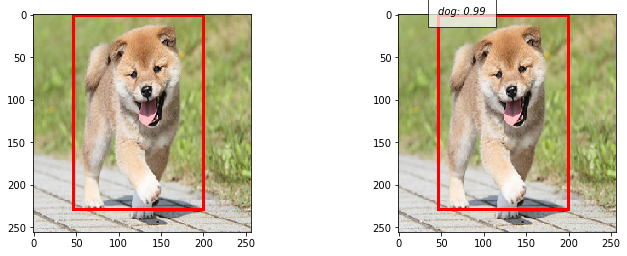

In [0]:
# 推論結果出力
res = random.choice(pred_list) #pred_list[0]
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots(1,2)
vis_bbox(res[0], res[1], res[2], ax=ax[0])
vis_bbox(res[0], res[1], res[2], res[3], label_names=classes, ax=ax[1])
plt.show()